<a href="https://colab.research.google.com/github/BinayakSinha/BengaliTrans/blob/main/Tensor_Quantum_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
# Data Processing tools
import numpy as np
from sklearn.model_selection import train_test_split
# QML tools
import tensorflow_quantum as tfq
import cirq
import sympy
# Visualization Tools
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

In [3]:
print("We are using the TensorFlow-Quantum version {}".format(tfq.__version__))
print("We are using the Cirq version {}".format(cirq.__version__))

We are using the TensorFlow-Quantum version 0.7.2
We are using the Cirq version 1.3.0


In [4]:
#Import DataSet
from tensorflow.keras.datasets import fashion_mnist as dataset

In [5]:
(X_train, y_train), (X_test, y_test) = dataset.load_data()

In [6]:
print("The shape of the X_train is {}".format( X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_test is {}".format(X_test.shape))
print("The shape of the y_test is {}".format(y_test.shape))

The shape of the X_train is (60000, 28, 28)
The shape of the y_train is (60000,)
The shape of the X_test is (10000, 28, 28)
The shape of the y_test is (10000,)


In [7]:
def filter_data(x, y):
  """
  Helper Function to filter the dataset
  """
  keep = (y == 5) | (y == 9)
  x, y = x[keep], y[keep]
  y = y == 5
  return x,y

In [8]:
X_train, y_train = filter_data(X_train, y_train)
X_test, y_test = filter_data(X_test, y_test)

In [9]:
print("The shape of the X_train is {}".format( X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_test is {}".format(X_test.shape))
print("The shape of the y_test is {}".format(y_test.shape))

The shape of the X_train is (12000, 28, 28)
The shape of the y_train is (12000,)
The shape of the X_test is (2000, 28, 28)
The shape of the y_test is (2000,)


Its a Boot? False


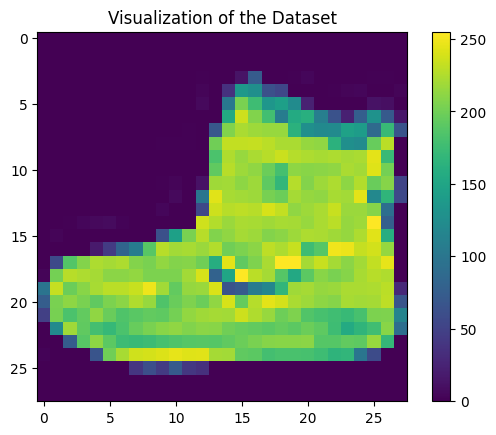

In [10]:
print("Its a Boot? {}".format(y_train[0]))
plt.imshow(X_train[0])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

In [11]:
X_train = X_train/255.0
X_test = X_test/ 255.0

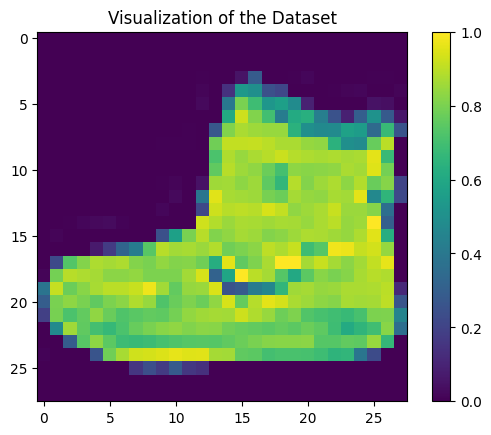

In [12]:
plt.imshow(X_train[0])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

In [13]:
X_train = X_train.reshape(X_train.shape[0], *(28,28,1))
X_test = X_test.reshape(X_test.shape[0], *(28,28,1))

In [14]:
X_train = tf.image.resize(X_train, (2,2)).numpy()
X_test = tf.image.resize(X_test, (2,2)).numpy()

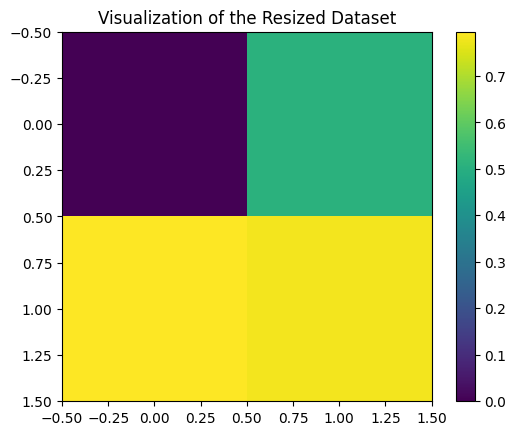

In [15]:
plt.imshow(X_train[0,:,:,0])
plt.colorbar()
plt.title('Visualization of the Resized Dataset')
plt.show()

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state=0)

In [17]:
print("The shape of the X_train is {}".format(X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_valid is {}".format(X_valid.shape))
print("The shape of the y_valid is {}".format(y_valid.shape))

The shape of the X_train is (10200, 2, 2, 1)
The shape of the y_train is (10200,)
The shape of the X_valid is (1800, 2, 2, 1)
The shape of the y_valid is (1800,)


In [18]:
X_train = X_train.reshape(X_train.shape[0], *(1,4,1))
X_valid = X_valid.reshape(X_valid.shape[0], *(1,4,1))
X_test = X_test.reshape(X_test.shape[0], *(1,4,1))

In [19]:
#Sample1
print(X_train[0])

[[[0.        ]
  [0.41568628]
  [0.7137255 ]
  [0.73921573]]]


In [20]:
def binary_encode(X,threshold=0.5):
  """
  Encodes the given datset to use binary encoding
  Parameters:
  X(array) : Image data to be processed for encoding
  threshold(float): Threshold for binary encoding, 0.5 by default
  Returns:
  encoded_images(array): Binary encoded Image Data
  """
  encoded_images = list()
  for image in X:
    # pixel value is 1 if it's greater than threshold or else zero
    encoded_image = [1 if j>threshold else 0 for j in image[0]]
    encoded_images.append(encoded_image)
  return np.array(encoded_images)

In [21]:
X_train = binary_encode(X_train)

In [22]:
print(X_train[0])

[0 0 1 1]


In [23]:
print("The shape of the X_train is {}".format(X_train.shape))

The shape of the X_train is (10200, 4)


In [24]:
def create_circuit_from_image(encoded_image):
  """
  Returns a circuit for given encoded image
  Parameters:
  encoded_image (array): Encoded Image
  Returns:
  circuit (cirq.Circuit object): cirq circuit
  """
  qubits = cirq.GridQubit.rect(2,2)
  circuit = cirq.Circuit()
  for i, pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [25]:
X_train = [create_circuit_from_image(encoded_image) for encoded_image in X_train]
print(X_train[0])
X_train_tfq = tfq.convert_to_tensor(X_train)

(1, 0): ───X───

(1, 1): ───X───


In [26]:
X_valid = binary_encode(X_valid)
X_test = binary_encode(X_test)
X_valid = [create_circuit_from_image(encoded_image) for encoded_image in X_valid]
X_test = [create_circuit_from_image(encoded_image) for encoded_image in X_test]
X_valid_tfq = tfq.convert_to_tensor(X_valid)
X_test_tfq = tfq.convert_to_tensor(X_test)

In [27]:
class QNN():
    def __init__(self, data_qubits, readout):
      self.data_qubits = data_qubits
      self.readout = readout

    def add_singleQubit_gate(self,circuit, gate, qubit_index):
      """
      Adds single qubit gate to the circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      qubits(list): index of qubits to apply the gate
      Returns:
      None
      """
      for index in qubit_index:
        circuit.append(gate(self.data_qubits[index]))

    def add_twoQubit_gate(self,circuit, gate, qubit_index):
      """
      Adds two qubit gate to the circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      qubits(list): index of qubits to apply the gate
      Returns:
      None
      """
      if len(qubit_index)!=2:
        raise Exception("The length of the list of indices passed for two qubit \
        gate operations must be equal to two")
      circuit.append(gate(self.data_qubits[qubit_index[0]], self.data_qubits[qubit_index[1]]))

    def add_layer(self, circuit, gate, symbol_gate):
      """
      Adds New Gates/Layers to the Circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      symbol_gate(string): symbol for the gate
      Returns:
      None
      """
      for i, qubit in enumerate(self.data_qubits):
        symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
        circuit.append(gate(qubit, self.readout)**symbol)

def create_qnn():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(2,2)
    readout = cirq.GridQubit(-1, -1)
    circuit = cirq.Circuit()
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    qnn = QNN(
        data_qubits = data_qubits,
        readout=readout)

    """
    qnn.add_singleQubit_gate(circuit, cirq.H, [0,1,2,3])
    qnn.add_twoQubit_gate(circuit, cirq.CNOT, [0, 1])
    qnn.add_twoQubit_gate(circuit, cirq.CNOT, [2, 3])
    """
    qnn.add_layer(circuit, cirq.XX, "xx")
    qnn.add_layer(circuit, cirq.ZZ, "zz")

    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

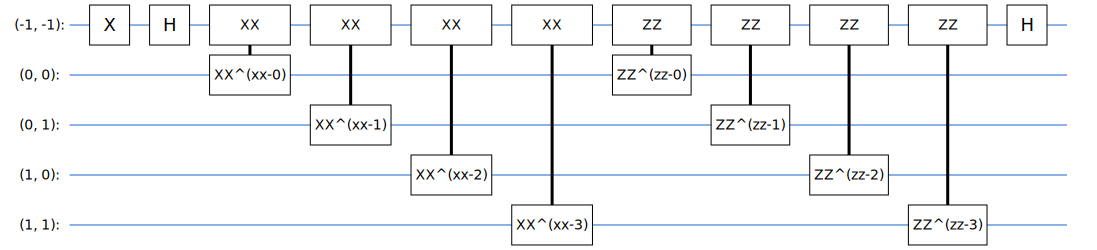

In [28]:
qmodel, model_readout = create_qnn()
SVGCircuit(qmodel)


In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(qmodel, model_readout),
])
y_train_h = np.array([1 if i==1 else -1 for i in y_train ])
y_valid_h = np.array([1 if i==1 else -1 for i in y_valid ])
y_test_h = np.array([1 if i==1 else -1 for i in y_test ])

print(y_train_h[0])
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

1


In [30]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[hinge_accuracy])


qnn_history = model.fit(
      X_train_tfq, y_train_h,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(X_valid_tfq, y_valid_h))

Epoch 1/10
160/160 [==============================] - 11s 59ms/step - loss: 0.7011 - hinge_accuracy: 0.7737 - val_loss: 0.5382 - val_hinge_accuracy: 0.7915
Epoch 2/10
160/160 [==============================] - 8s 51ms/step - loss: 0.4970 - hinge_accuracy: 0.7879 - val_loss: 0.4143 - val_hinge_accuracy: 0.8626
Epoch 3/10
160/160 [==============================] - 9s 55ms/step - loss: 0.4174 - hinge_accuracy: 0.8520 - val_loss: 0.3958 - val_hinge_accuracy: 0.8351
Epoch 4/10
160/160 [==============================] - 10s 63ms/step - loss: 0.4011 - hinge_accuracy: 0.8197 - val_loss: 0.3974 - val_hinge_accuracy: 0.7958
Epoch 5/10
160/160 [==============================] - 16s 98ms/step - loss: 0.3970 - hinge_accuracy: 0.8027 - val_loss: 0.3993 - val_hinge_accuracy: 0.7958
Epoch 6/10
160/160 [==============================] - 11s 68ms/step - loss: 0.3953 - hinge_accuracy: 0.8028 - val_loss: 0.4004 - val_hinge_accuracy: 0.7958
Epoch 7/10
160/160 [==============================] - 11s 70ms/ste

In [31]:
model.evaluate(X_test_tfq, y_test_h)

63/63 [==============================] - 1s 14ms/step - loss: 0.3674 - hinge_accuracy: 0.8229


[0.3674164414405823, 0.8229166865348816]

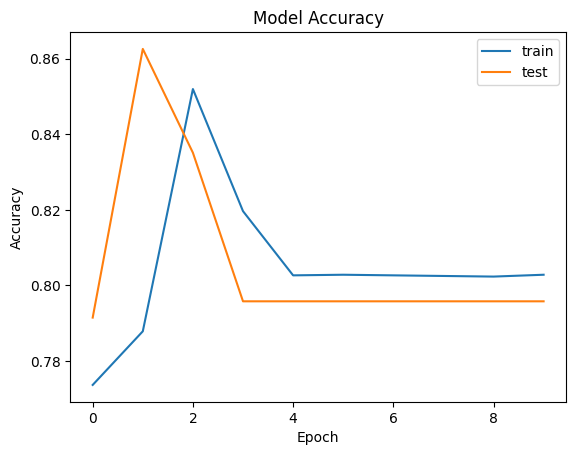

In [32]:
# Visualize accuracy
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

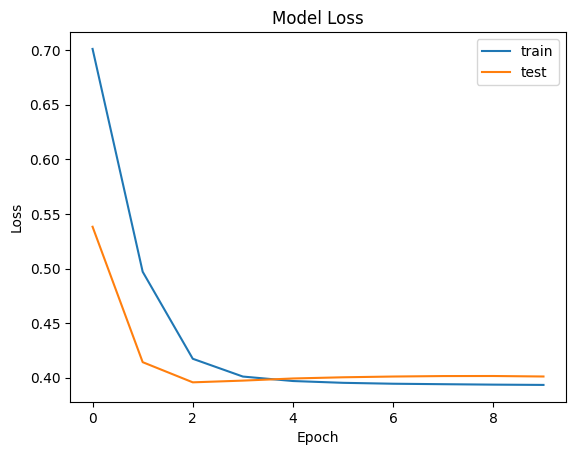

In [33]:
# Visualize Loss
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'],loc="best")
plt.show()

In [34]:
model.save_weights('/content/sample_data/QModelWeights')